In [1]:
from pyspark.sql import SparkSession;

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession;

spark = SparkSession.builder.master("local[4]").appName("Spark Assignment").enableHiveSupport().getOrCreate();
# NOTE: 'local[4]' means that we are using 4 threads to run this spark session.

# note: If you have multiple spark sessions running (like from a previous notebook you've run), 
# this spark session webUI will be on a different port than the default (4040). One way to 
# identify this part is with the following line. If there was only one spark session running, 
# this will be 4040. If it's higher, it means there are still other spark sesssions still running.
spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/12 15:06:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session WebUI Port: 4040


In [3]:
# Set Spark log level to ERROR to reduce verbosity
spark.sparkContext.setLogLevel("ERROR")

In [4]:
spark

In [5]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F, Row
from pyspark.sql.types import IntegerType, DoubleType, StringType, ArrayType, StructType, StructField
from pyspark.sql.functions import col, lower, regexp_replace, regexp_extract, split, lit, input_file_name, size, udf
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA, ChiSqSelector
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

import nltk
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
np.random.seed(42)

# Business Context

### Business Context: Leveraging Comments for Sentiment Analysis in the Movie Industry

User comments and reviews in the movie industry serve as a valuable source of insights into audience preferences and reactions. By analyzing the sentiment in these reviews, businesses—such as production companies, streaming services, and marketing teams—can gain a better understanding of audience responses, allowing them to make more informed, strategic decisions.

**Key Benefits of Sentiment Analysis in the Movie Industry:**

1. **Gauge Public Reception:** 
   - Positive sentiment often correlates with a movie's success, indicating potential for strong performance at the box office or on streaming platforms.
   - Negative sentiment can highlight issues with plot, characters, or production, providing filmmakers with actionable feedback.

2. **Enhance Content Recommendations:**
   - Streaming platforms can leverage sentiment analysis to improve recommendation algorithms. For instance, users who frequently watch positively-reviewed films could be recommended similar content, increasing engagement and satisfaction.

3. **Optimize Marketing Strategies:**
   - By analyzing sentiment trends, marketing teams can tailor campaigns to audience preferences. For example, if specific actors or plot elements receive highly positive feedback, marketing materials can focus on these to attract similar audiences.

4. **Guide Future Productions:**
   - Studios can use sentiment data to identify recurring audience preferences. Consistently high ratings for certain genres or themes can encourage studios to invest in similar content, aligning future productions with viewer interests.

By training sentiment prediction models on text data from reviews, the movie industry can make data-driven decisions that enhance audience satisfaction, deliver personalized experiences, and ultimately increase revenue.


### Business Context: Leveraging Comments for Sentiment Analysis in the Movie Industry

User comments and reviews in the movie industry serve as a valuable source of insights into audience preferences and reactions. By analyzing the sentiment in these reviews, businesses—such as production companies, streaming services, and marketing teams—can gain a better understanding of audience responses, allowing them to make more informed, strategic decisions.

**Key Benefits of Sentiment Analysis in the Movie Industry:**

1. **Gauge Public Reception:** 
   - Positive sentiment often correlates with a movie's success, indicating potential for strong performance at the box office or on streaming platforms.
   - Negative sentiment can highlight issues with plot, characters, or production, providing filmmakers with actionable feedback.

2. **Enhance Content Recommendations:**
   - Streaming platforms can leverage sentiment analysis to improve recommendation algorithms. For instance, users who frequently watch positively-reviewed films could be recommended similar content, increasing engagement and satisfaction.

3. **Optimize Marketing Strategies:**
   - By analyzing sentiment trends, marketing teams can tailor campaigns to audience preferences. For example, if specific actors or plot elements receive highly positive feedback, marketing materials can focus on these to attract similar audiences.

4. **Guide Future Productions:**
   - Studios can use sentiment data to identify recurring audience preferences. Consistently high ratings for certain genres or themes can encourage studios to invest in similar content, aligning future productions with viewer interests.

By training sentiment prediction models on text data from reviews, the movie industry can make data-driven decisions that enhance audience satisfaction, deliver personalized experiences, and ultimately increase revenue.


### Data Loading

In this section, we load movie reviews from both the training and testing folders. The data from these sources is then combined into a single Spark DataFrame, `reviews_df`, for streamlined processing and analysis in the subsequent steps.

In [6]:
# Path to the dataset directories
train_pos_path = "train/pos/"
train_neg_path = "train/neg/"
test_pos_path = "test/pos/"
test_neg_path = "test/neg/"

# Function to load data from a directory into a Spark DataFrame
def load_data(path, sentiment):
    df = spark.read.text(path).withColumn("sentiment", lit(sentiment))
    df = df.withColumn("filename", input_file_name())
    df = df.withColumn("rating", regexp_extract("filename", "_(\\d+)", 1).cast("integer"))
    df = df.drop("filename")
    return df

# Loading data
train_pos_df = load_data(train_pos_path, 1)  # Positive sentiment
train_neg_df = load_data(train_neg_path, 0)  # Negative sentiment
test_pos_df = load_data(test_pos_path, 1)
test_neg_df = load_data(test_neg_path, 0)

# Combine all data into a single DataFrame
from pyspark.sql import DataFrame
reviews_df = train_pos_df.union(train_neg_df).union(test_pos_df).union(test_neg_df)

Here, we have read all text files from the folders, assigned sentiments based on their subfolder name, and extracted ratings from the filename.


# Data Schema and Transformation

In this step, we examine the data schema and perform initial transformations, including renaming columns and preparing the text for further Exploratory Data Analysis (EDA).

In [7]:
# Print the schema of the DataFrame
reviews_df.printSchema()

root
 |-- value: string (nullable = true)
 |-- sentiment: integer (nullable = false)
 |-- rating: integer (nullable = true)



## 1. Handling Schema

After reviewing the initial data schema, a few transformations are applied to improve clarity and usability for further analysis:

#### 1. Column Renaming
The original column name 'value' is not descriptive of its content. As it contains the text of movie reviews, it has been renamed to 'review' to better reflect its contents.

#### 2. Data Types Review
The data types of all columns align with the requirements for subsequent transformations and analysis:
- **review**: string
- **sentiment**: integer
- **rating**: integer

No additional data type changes are needed at this stage.

#### 3. Handling Complex Data Structures
The dataset is flat, with no nested or complex data structures. This simplicity aids in our analysis, as no special handling of complex data structures is required.


In [8]:
# Rename the 'value' column to 'review'
reviews_df = reviews_df.withColumnRenamed("value", "review")
reviews_df.printSchema()

root
 |-- review: string (nullable = true)
 |-- sentiment: integer (nullable = false)
 |-- rating: integer (nullable = true)



In [9]:
# Display the first 5 rows of the DataFrame with text truncated to 50 characters
reviews_df.show(5, truncate=50)

+--------------------------------------------------+---------+------+
|                                            review|sentiment|rating|
+--------------------------------------------------+---------+------+
|Match 1: Tag Team Table Match Bubba Ray and Spi...|        1|     9|
|**Attention Spoilers**<br /><br />First of all,...|        1|     9|
|Titanic directed by James Cameron presents a fi...|        1|     9|
|By now you've probably heard a bit about the ne...|        1|    10|
|*!!- SPOILERS - !!*<br /><br />Before I begin t...|        1|    10|
+--------------------------------------------------+---------+------+
only showing top 5 rows



## 2. Data Transformations

This step focuses on preparing the data for analysis by applying essential transformations and feature engineering. Data cleansing is performed to handle missing values, remove duplicates, and ensure consistent text formatting.

### Initial Text Processing
1. **Removing Punctuation and Converting to Lowercase**: Standardizes text by removing punctuation and converting to lowercase.
2. **Removing HTML Tags**: Strips any HTML tags from the text for cleaner analysis.
3. **Handling Missing Values**: Checks for and addresses any missing values in the dataset.
4. **Dropping Duplicates**: Ensures unique entries by removing duplicate reviews.

### Feature Engineering
Additional features are created to enrich the dataset, providing useful metrics for analysis:
1. **Word Count**: Counts the total words in each review, providing a measure of review length.
2. **Count of Exclamation Marks**: Identifies the frequency of exclamation marks, which can indicate emotional intensity.
3. **Tokenization**: Breaks down each review into individual words (tokens).
4. **Stopword Removal**: Removes common, uninformative words to focus on meaningful terms.
5. **Lemmatization**: Reduces words to their base forms, ensuring uniformity.
6. **Sentiment Word Analysis**: Counts predefined positive and negative words within each review to assess sentiment.

These transformations and features prepare the data for effective analysis, adding structure and clarity to the text data.


### Initial Text Processing

**a. Removing Punctuation and Converting to Lowercase**
- This step standardizes the text by removing punctuation marks and converting all characters to lowercase, ensuring consistency across the dataset.

In [10]:
# Just before removing punctuation marks, we will count the number of exclamation marks as their presence 
# generally indicates heightened emotion or intensity rather than a specific sentiment direction

reviews_df = reviews_df.withColumn("exclamation_count", F.length(F.regexp_replace(col("review"), "[^!]", "")))

In [11]:
# Removing punctuation and converting text to lowercase

reviews_df = reviews_df.withColumn("review", F.lower(F.regexp_replace(F.col("review"), "[^a-zA-Z\\s]", "")))
reviews_df.show(5, truncate=50)

+--------------------------------------------------+---------+------+-----------------+
|                                            review|sentiment|rating|exclamation_count|
+--------------------------------------------------+---------+------+-----------------+
|match  tag team table match bubba ray and spike...|        1|     9|               30|
|attention spoilersbr br first of all let me say...|        1|     9|                1|
|titanic directed by james cameron presents a fi...|        1|     9|                0|
|by now youve probably heard a bit about the new...|        1|    10|                1|
| spoilers  br br before i begin this let me say...|        1|    10|               12|
+--------------------------------------------------+---------+------+-----------------+
only showing top 5 rows



**b. Removing HTML Tags**
- We notice that the `<br>` tag frequently appears in the text, indicating other HTML tags may also be present. Since punctuation has already been removed, simply removing common tags (like `<br>`) will help clean the data. To avoid impacting similar words (e.g., “break”), we specifically target standalone HTML tags for removal.


In [12]:
# List of most common HTML tags to remove (you can expand this list as needed)
html_tags = ['br ', 'div ', 'p ', 'a ', 'li ', 'ul ', 'ol ', 'span ', 
             'h1 ', 'h2 ', 'h3 ', 'h4 ', 'h5 ', 'h6 ', 'tr ', 'td ']


html_tag_regex = '|'.join(html_tags)  # Creates a regex pattern like 'br|div|span|...'
html_tag_pattern = f"\\b({html_tag_regex})\\b"

# Removing HTML tags by replacing them with an empty string
reviews_df = reviews_df.withColumn("review", F.regexp_replace(col("review"), html_tag_pattern, ""))
reviews_df.show(5, truncate=50)

+--------------------------------------------------+---------+------+-----------------+
|                                            review|sentiment|rating|exclamation_count|
+--------------------------------------------------+---------+------+-----------------+
|match  tag team table match bubba ray and spike...|        1|     9|               30|
|attention spoilersbr first of all let me say th...|        1|     9|                1|
|titanic directed by james cameron presents fict...|        1|     9|                0|
|by now youve probably heard bit about the new d...|        1|    10|                1|
| spoilers  before i begin this let me say that ...|        1|    10|               12|
+--------------------------------------------------+---------+------+-----------------+
only showing top 5 rows



In [13]:
reviews_df.show(5, truncate=50)

+--------------------------------------------------+---------+------+-----------------+
|                                            review|sentiment|rating|exclamation_count|
+--------------------------------------------------+---------+------+-----------------+
|match  tag team table match bubba ray and spike...|        1|     9|               30|
|attention spoilersbr first of all let me say th...|        1|     9|                1|
|titanic directed by james cameron presents fict...|        1|     9|                0|
|by now youve probably heard bit about the new d...|        1|    10|                1|
| spoilers  before i begin this let me say that ...|        1|    10|               12|
+--------------------------------------------------+---------+------+-----------------+
only showing top 5 rows



> All the unnecessary punctuations, html tags have been removed and we can see the text is clean in lowercase alphanumeric characters. 

**c. Handling Missing Values**
- This step involves checking for any missing or null values in the data and remove them as they can affect the accuracy of your analysis.

In [14]:
# Checking for null values in the DataFrame
reviews_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in reviews_df.columns]).show()

+------+---------+------+-----------------+
|review|sentiment|rating|exclamation_count|
+------+---------+------+-----------------+
|     0|        0|     0|                0|
+------+---------+------+-----------------+



> There are no null values in the current dataset, so handling them isn't necessary. However, in cases where null values might be present in future inputs, the following code is used to drop rows with null values.

In [15]:
# Dropping any rows that have missing values in any column
reviews_df = reviews_df.na.drop()

**d. Dropping Duplicate Rows**
- This step involves dropping duplicate columns if any exists in the dataset to avoid redundancy

In [16]:
# Initial Size of Dataset
reviews_df.count()

50000

In [17]:
# Removing duplicate rows based on 'review' and 'sentiment' columns
reviews_df = reviews_df.dropDuplicates(["review", "sentiment", "rating"])

# Size after removing duplicates
reviews_df.count()

49585

> This indicates that there were some duplicate reviews in the dataset, which have now been successfully removed.

## Feature Engineering
Feature engineering is a crucial step in preparing our dataset for deeper analysis and modeling.

**a. Word Count:** 
- Calculating the number of words in each review provides a foundational feature for text analysis tasks. This metric can correlate with the intensity of sentiment, as longer reviews may reflect more detailed and nuanced opinions.


In [18]:
# Calculating the number of words in each review
reviews_df = reviews_df.withColumn("word_count", size(split(col("review"), " ")))

**b. Presence of Exclamation Marks**(Already done before removing Punctuations)
- This step involves counting the exclamation marks as exclamation marks can indicate strong emotions, which is often related to sentiment.

In [19]:
# Calculating the number of Exclamation Marks in each review
# - this step was performed before removing punctuation marks.

**c. Tokenization**
- This step involves breaking down the text into tokens (words), as this makes the subsequent steps more manageable and structured

In [20]:
# Tokenize the text to break down the review into words
tokenizer = Tokenizer(inputCol="review", outputCol="words")
reviews_df = tokenizer.transform(reviews_df)

**d. Stopwords Removal**
- This step involves removing common words that do not contribute significant meaning to the content.
- I am using custom stopwords because, using all the stopwords could actually remove words like `isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't", "don't", "doesn't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "can't", "couldn't", 'cannot'`, but these words are crucial in case of sentiment seperation.

In [21]:
# Define a basic list of stopwords (verbs, prepositions, conjunctions)
# Expanded comprehensive stopwords list
basic_stopwords = [
    "is", "are", "was", "were", "be", "been", "am", "will", "would", "shall", "should", 
    "can", "could", "may", "might", "to", "from", "in", "on", "at", "with", "and", 
    "or", "but", "if", "the", "of", "it", "i", "this", "that", "he", "her", "she", 
    "him", "his", "they", "their", "them", "there", "who", "ha", "my", "mine", "you", 
    "your", "we", "our", "all", "what", "why", "how", "when", "where", "which", "a",
    "for", "by", "about", "into", "up", "down", "out", "as", "an", "so", "just", 
    "has", "have", "had", "having", "do", "does", "did", "doing", 
    "some", "any", "these", "those", "its", "then", "than", "once", "over", "under", 
    "again", "being", "because", "through", "off", "between", "before", "after", "such", 
    "until", "against", "during", "each", "both", "while", "further", "few", "must", "movie",
    "film", "one", "even", "too", "still", ""
]


# Apply the custom stopwords using StopWordsRemover
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=basic_stopwords)

# Apply the transformation to your DataFrame
reviews_df = remover.transform(reviews_df)

**e. Lemmatization**
- Lemmatization is a process of reducing words to their base or dictionary form (lemma), considering the morphological analysis of the words

In [22]:
# Ensure necessary resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define a UDF to apply lemmatization using NLTK's WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatization_udf = udf(lambda words: [lemmatizer.lemmatize(word) for word in words], ArrayType(StringType()))

# Apply lemmatization to the filtered words and update the review column
reviews_df = reviews_df.withColumn("review", lemmatization_udf("filtered_words"))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/harshasaijagu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/harshasaijagu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**f. Sentiment Words Count**(After Stemming)
- This step involves counting predefined positive and negative words can provide direct insights into the sentiment of the review.
- This is done after stemming because, this ensures all forms of the word are recognized and counted correctly.


In [23]:
# Define comprehensive lists of positive and negative sentiment words
positive_words = [
    "excellent", "great", "perfect", "amazing", "positive", "enjoyable", "best",
    "wonderful", "fantastic", "loved", "liked", "brave", "good", "beautiful",
    "joyful", "happy", "satisfying", "delightful", "superb", "marvelous",
    "outstanding", "thrilling", "captivating", "charming", "impressive", "incredible",
    "stunning", "heartwarming", "uplifting", "rewarding", "memorable", "entertaining",
    "inspiring", "appealing", "engaging", "yes", "like", 
]

negative_words = [
    "bad", "worst", "terrible", "negative", "boring", "poor", "disappointing", "dull",
    "hated", "disliked", "awful", "horrible", "dreadful", "lame", "annoying", "crazy",
    "mad", "disgusting", "painful", "unwatchable", "monotonous", "tedious",
    "uninteresting", "lackluster", "predictable", "uninspired", "flop", "misfire",
    "bland", "soulless", "tiresome", "mundane", "flawed", "clumsy", "stale", "no", "not", 
    "wrong", 

]

In [24]:
# UDF to count positive and negative words
def count_words_in_list(words, word_list):
    return sum(1 for word in words if word in word_list)

count_positive_words_udf = udf(lambda words: count_words_in_list(words, positive_words), IntegerType())
count_negative_words_udf = udf(lambda words: count_words_in_list(words, negative_words), IntegerType())

# Applying the UDFs to count occurrences of sentiment words
reviews_df = reviews_df.withColumn("positive_word_count", count_positive_words_udf("review"))
reviews_df = reviews_df.withColumn("negative_word_count", count_negative_words_udf("review"))

In [25]:
# Show the updated DataFrame after Feature Engineering
reviews_df.select('review', 'word_count', 'exclamation_count', 'positive_word_count', 'negative_word_count').show(5, truncate=25)

+-------------------------+----------+-----------------+-------------------+-------------------+
|                   review|word_count|exclamation_count|positive_word_count|negative_word_count|
+-------------------------+----------+-----------------+-------------------+-------------------+
|[looking, glass, see, ...|       962|                0|                  7|                 10|
|[hong, kong, given, wo...|      1027|                3|                 25|                  4|
|[anchor, aweigh, see, ...|      1039|                5|                 13|                  4|
|[angelopoulos, film, s...|       958|                0|                  4|                 10|
|[second, two, filmed, ...|       948|                0|                 11|                  8|
+-------------------------+----------+-----------------+-------------------+-------------------+
only showing top 5 rows



> From this, we can see that all the feature-engineered columns have been successfully added to the DataFrame, and the `review` column has been transformed through tokenization, stopword removal, and lemmatization.

# Data Storage

This step involves storing the data into persistent tables. Before storing the data into persistent tables, it's important to finalize the DataFrame schema to ensure it is ready for storage.

In [26]:
reviews_df.printSchema()

root
 |-- review: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment: integer (nullable = false)
 |-- rating: integer (nullable = true)
 |-- exclamation_count: integer (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- positive_word_count: integer (nullable = true)
 |-- negative_word_count: integer (nullable = true)



From the schema, we can observe that:

1. The `review` column is currently an array of words. To improve readability, it would be better to concatenate the words back into a single string.
2. The `words` and `filtered_words` columns are no longer needed, as the processed data is now fully contained in the `review` column. Dropping these columns will help reduce memory usage.

In [27]:
# Concatenate the 'review' array back into a single string column
reviews_df = reviews_df.withColumn("review", F.concat_ws(" ", "review"))

In [28]:
# Drop the 'words' and 'filtered_words' columns from the DataFrame
reviews_df = reviews_df.drop("words", "filtered_words")

In [29]:
# Check the updated DataFrame schema
reviews_df.printSchema()

root
 |-- review: string (nullable = false)
 |-- sentiment: integer (nullable = false)
 |-- rating: integer (nullable = true)
 |-- exclamation_count: integer (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- positive_word_count: integer (nullable = true)
 |-- negative_word_count: integer (nullable = true)



The DataFrame is now fully flattened with an optimized schema, making it ready for storage in a persistent table. This streamlined structure is well-suited for efficient querying and analysis.

In [30]:
# Create the database 'movie_reviews_db' if it does not exist
spark.sql("CREATE DATABASE IF NOT EXISTS movie_reviews_db")

DataFrame[]

In [31]:
spark.sql("show databases").show()

+----------------+
|       namespace|
+----------------+
|         default|
|movie_reviews_db|
+----------------+



In [32]:
spark.sql("USE movie_reviews_db")

DataFrame[]

In [33]:
# Save the DataFrame as a persistent table with the name 'movie_reviews'
reviews_df.write.mode('overwrite').saveAsTable("movie_reviews")

# To confirm the table is created and to inspect some entries
spark.sql("SELECT * FROM movie_reviews").show(5, truncate=20)

+--------------------+---------+------+-----------------+----------+-------------------+-------------------+
|              review|sentiment|rating|exclamation_count|word_count|positive_word_count|negative_word_count|
+--------------------+---------+------+-----------------+----------+-------------------+-------------------+
|nyc seaman michae...|        1|    10|                0|       961|                  4|                  5|
|director douglas ...|        1|    10|                0|      1113|                 11|                  9|
|jim carrey back m...|        1|     9|                1|      1240|                 22|                  4|
|most important ar...|        1|     7|                0|       971|                 13|                  4|
|many adaptation c...|        1|    10|                0|       977|                 11|                 11|
+--------------------+---------+------+-----------------+----------+-------------------+-------------------+
only showing top 5 

> The data is saved in a structured format within a newly created database called `movie_reviews_db`. The processed DataFrame has been stored in a persistent table named `movie_reviews`, ensuring that the data is accessible for efficient querying and further analysis.

# Temporary View Creation

In [34]:
# Create a temporary view in Spark SQL
reviews_df.createOrReplaceTempView("movie_reviews_view")

> We have created a temporary view because it allows us to perform SQL queries directly on the data, making exploratory data analysis more efficient and intuitive. Using SQL simplifies complex transformations, improves code readability, and enables interactive analysis without modifying the original DataFrame. This approach also leverages Spark's optimization capabilities, ensuring better performance, especially when handling large datasets

# Part1 - Data Exploration with Spark SQL

This phase involves conducting exploratory data analysis (EDA) using Spark SQL to uncover insights from the dataset. We will perform aggregations, summaries, and various SQL queries to explore the relationships and trends in the data. Visualizations will also be created to aid in understanding the results.

- a. Statistical Summaries
- b. Group Data by Sentiment
- c. Review Length vs. Sentiment
- d. Sentiment Word Analysis
- e. Average Exclamation Mark Count by Rating
- f. Review Length Distribution by Rating
- g. Word Cloud: Most Common Words in Positive and Negative Reviews

This exploration will provide insights into the characteristics of the dataset and help reveal patterns related to sentiment, review content, and movie ratings.

In [35]:
%load_ext sparksql_magic

**a. Statistical Summaries**
- Calculate key statistical measures for numerical fields:
  - Mean Rating
  - Median Rating
  - Mean Word count
  - Median Word Count

In [36]:
%%sparksql
SELECT 
    AVG(rating) AS mean_rating, 
    PERCENTILE_APPROX(rating, 0.5) AS median_rating, 
    AVG(word_count) AS mean_word_count, 
    PERCENTILE_APPROX(word_count, 0.5) AS median_word_count
FROM movie_reviews_view


mean_rating,median_rating,mean_word_count,median_word_count
5.508218211152566,7,222.77676716749016,167


**b. Group Data by Sentiment**
- Group the reviews by positive and negative sentiment and compute aggregated metrics such as:
  - Number of Reviews
  - Average rating for each sentiment
  - Average word count for each sentiment
  - Average number of exclamation marks for positive and negative reviews

In [37]:
%%sparksql
SELECT 
    sentiment, 
    COUNT(*) AS review_count, 
    AVG(rating) AS avg_rating, 
    AVG(word_count) AS avg_word_count,
    AVG(exclamation_count) AS avg_exclamation_marks
FROM movie_reviews_view
GROUP BY sentiment


sentiment,review_count,avg_rating,avg_word_count,avg_exclamation_marks
1,24887,8.76915658777675,224.43898420862297,0.929561618515691
0,24698,2.2223256943882097,221.10183010770103,1.027492104623856


In [38]:
# Run the SQL query and convert to a Pandas DataFrame
result_df = spark.sql("""
    SELECT 
        sentiment, 
        COUNT(*) AS review_count, 
        AVG(rating) AS avg_rating, 
        AVG(word_count) AS avg_word_count,
        AVG(exclamation_count) AS avg_exclamation_marks
    FROM movie_reviews_view
    GROUP BY sentiment
""").toPandas()

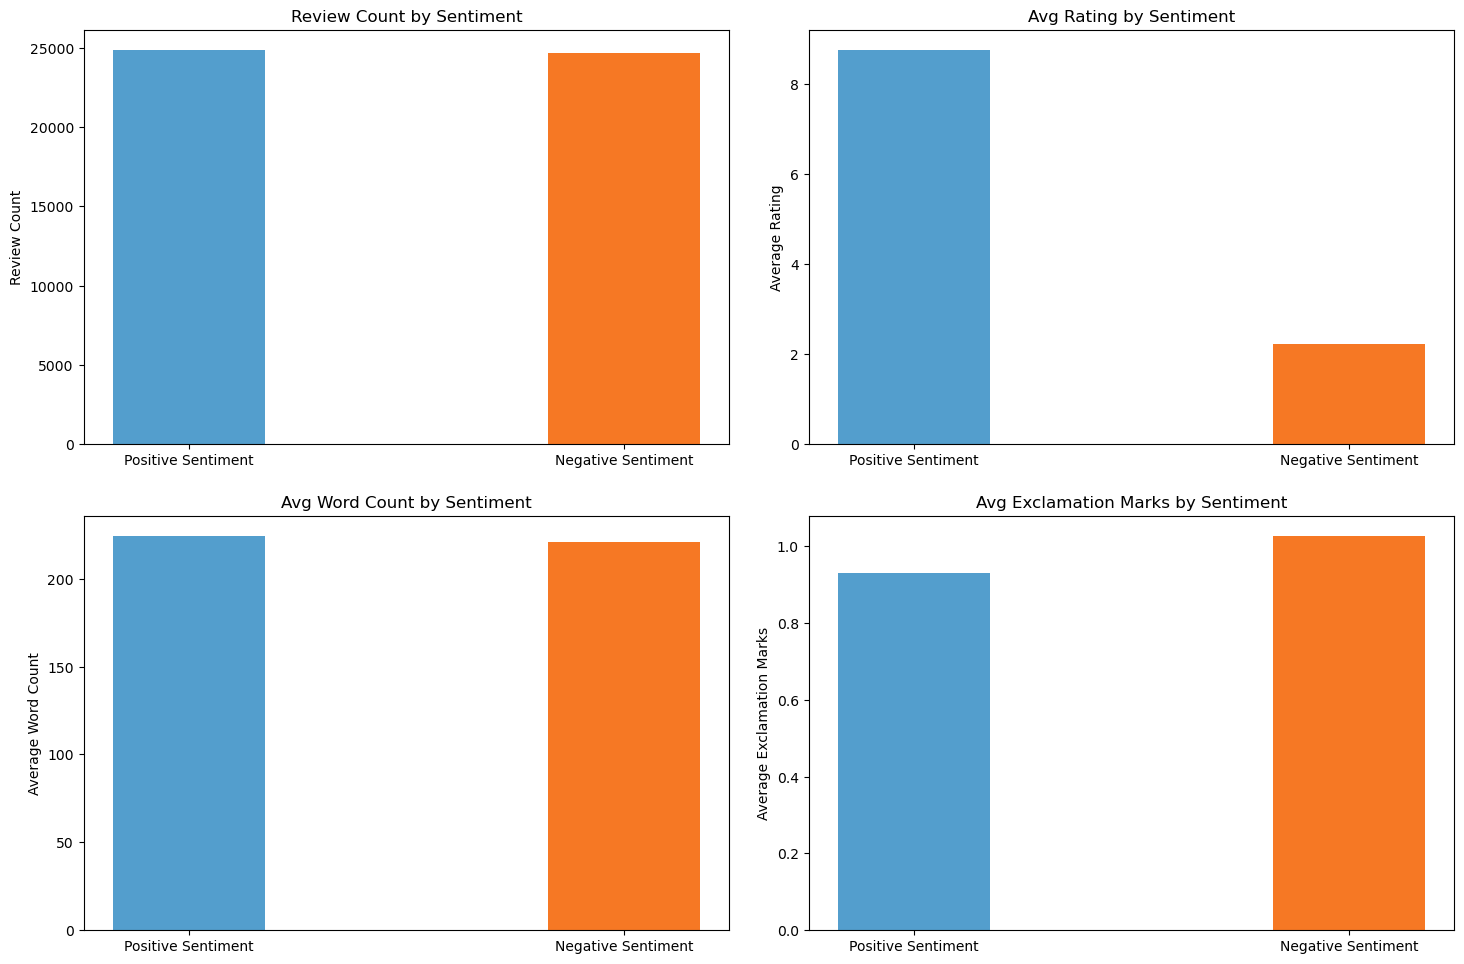

In [39]:
# Adjust the plot for better visual appeal, centering the bars in each subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Define the width of the bars and the position for each bar group
bar_width = 0.35
index = result_df['sentiment']

# Adjust the bar positions to be centered
index_positions = range(len(index))

# Use Seaborn color palette for better visuals
positive_color = sns.color_palette("Blues")[3]
negative_color = sns.color_palette("Oranges")[3]

# Review Count bar chart
axs[0, 0].bar(index_positions, result_df['review_count'], bar_width, 
              color=[negative_color if x == 0 else positive_color for x in result_df['sentiment']])
axs[0, 0].set_title('Review Count by Sentiment')
axs[0, 0].set_xticks(index_positions)
axs[0, 0].set_xticklabels(result_df['sentiment'].apply(lambda x: 'Negative Sentiment' if x == 0 else 'Positive Sentiment'))
axs[0, 0].set_ylabel('Review Count')

# Avg Rating bar chart
axs[0, 1].bar(index_positions, result_df['avg_rating'], bar_width, 
              color=[negative_color if x == 0 else positive_color for x in result_df['sentiment']])
axs[0, 1].set_title('Avg Rating by Sentiment')
axs[0, 1].set_xticks(index_positions)
axs[0, 1].set_xticklabels(result_df['sentiment'].apply(lambda x: 'Negative Sentiment' if x == 0 else 'Positive Sentiment'))
axs[0, 1].set_ylabel('Average Rating')

# Avg Word Count bar chart
axs[1, 0].bar(index_positions, result_df['avg_word_count'], bar_width, 
              color=[negative_color if x == 0 else positive_color for x in result_df['sentiment']])
axs[1, 0].set_title('Avg Word Count by Sentiment')
axs[1, 0].set_xticks(index_positions)
axs[1, 0].set_xticklabels(result_df['sentiment'].apply(lambda x: 'Negative Sentiment' if x == 0 else 'Positive Sentiment'))
axs[1, 0].set_ylabel('Average Word Count')

# Avg Exclamation Marks bar chart
axs[1, 1].bar(index_positions, result_df['avg_exclamation_marks'], bar_width, 
              color=[negative_color if x == 0 else positive_color for x in result_df['sentiment']])
axs[1, 1].set_title('Avg Exclamation Marks by Sentiment')
axs[1, 1].set_xticks(index_positions)
axs[1, 1].set_xticklabels(result_df['sentiment'].apply(lambda x: 'Negative Sentiment' if x == 0 else 'Positive Sentiment'))
axs[1, 1].set_ylabel('Average Exclamation Marks')

# Adjust layout to ensure bars are centered and have enough space around
plt.tight_layout(pad=2.0)
plt.show()


**Inference :** 

> **1. Review Count by Sentiment:** The count of positive and negative reviews is nearly equal, suggesting a balanced dataset in terms of sentiment distribution.

> **2. Avg Rating by Sentiment:** Positive reviews have a significantly higher average rating (~8+) compared to negative reviews (~2), which is expected as ratings tend to reflect the overall sentiment of the review.

> **3. Avg Word Count by Sentiment:** Positive and negative reviews have nearly the same average word count, indicating that review length may not be a strong indicator of sentiment.

> **4. Avg Exclamation Marks by Sentiment:** Negative reviews have a slightly higher use of exclamation marks on average, suggesting that reviewers may express stronger or more intense emotions when writing negatively about a movie.

**c. Review Length vs. Sentiment**
- Explore the relationship between review length (word count) and sentiment:
  - Does the length of the review correlate with the sentiment (positive or negative)?
  - Is there a significant difference in review length between positive and negative reviews?

In [40]:
%%sparksql
SELECT 
    CASE 
        WHEN word_count < 150 THEN 'Short Reviews'
        WHEN word_count BETWEEN 150 AND 300 THEN 'Medium Reviews'
        ELSE 'Long Reviews'
    END AS review_length_category,
    sentiment, COUNT(*) AS count
FROM movie_reviews_view
GROUP BY review_length_category, sentiment
ORDER BY review_length_category

review_length_category,sentiment,count
Long Reviews,1,5294
Long Reviews,0,5030
Medium Reviews,0,9406
Medium Reviews,1,8965
Short Reviews,0,10262
Short Reviews,1,10628


**Inference :** 
> The data suggests that there is no clear relationship between review length (categorized as short, medium, or long) and sentiment (positive or negative). The counts for positive and negative reviews are fairly balanced across all review length categories, implying that the length of the review does not significantly affect whether the sentiment is positive or negative.

**d. Sentiment Word Analysis**
- Analyze the counts of sentiment-related words in the reviews:
  - Average number of positive words in positive reviews vs. negative reviews
  - Average number of negative words in positive reviews vs. negative reviews

In [41]:
%%sparksql
SELECT sentiment, AVG(positive_word_count) AS avg_positive_words, AVG(negative_word_count) AS avg_negative_words
FROM movie_reviews_view
GROUP BY sentiment


sentiment,avg_positive_words,avg_negative_words
1,3.396431872061719,1.9570458472294772
0,2.343185683051259,3.752652036602154


In [42]:
# Run the SQL query and convert to a Pandas DataFrame
result_df = spark.sql("""
    SELECT sentiment, AVG(positive_word_count) AS avg_positive_words, AVG(negative_word_count) AS avg_negative_words
    FROM movie_reviews_view
    GROUP BY sentiment
""").toPandas()


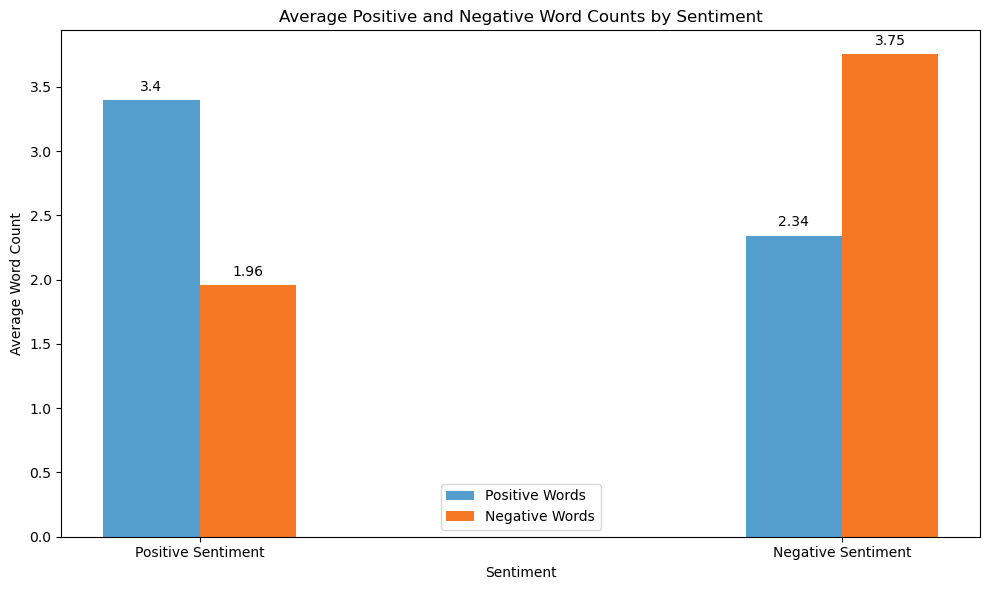

In [43]:
# Use Seaborn for appealing colors
positive_color = sns.color_palette("Blues")[3]
negative_color = sns.color_palette("Oranges")[3]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of the bars and the positions
bar_width = 0.15
index = np.arange(len(result_df))

# Plot the bars for positive and negative words
positive_bars = ax.bar(index, result_df['avg_positive_words'], bar_width, label='Positive Words', color=positive_color)
negative_bars = ax.bar(index + bar_width, result_df['avg_negative_words'], bar_width, label='Negative Words', color=negative_color)

# Add titles and labels
ax.set_xlabel('Sentiment')
ax.set_ylabel('Average Word Count')
ax.set_title('Average Positive and Negative Word Counts by Sentiment')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Positive Sentiment', 'Negative Sentiment'])
ax.legend()

# Add value labels on top of the bars
for bar in positive_bars + negative_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


**Inference :** 
> For positive sentiment reviews, there is a higher count of positive words compared to negative words, which is expected. On the other hand, for negative sentiment reviews, the count of negative words is significantly higher than positive words. This confirms that positive reviews tend to have more positive words and negative reviews tend to include more negative words, reflecting a clear alignment between word sentiment and overall review sentiment.

**e. Average Exclamation Mark Count by Rating**
- Investigate how the use of exclamation marks correlates with movie ratings:
  - Is there a pattern between the number of exclamation marks in a review and the movie’s rating?

In [44]:
%%sparksql
SELECT rating, AVG(exclamation_count) AS avg_exclamation_marks
FROM movie_reviews_view
GROUP BY rating
ORDER BY rating


rating,avg_exclamation_marks
1,1.3243785084202084
2,0.9770773638968482
3,0.858454007750357
4,0.6669822037107156
7,0.6162523501148945
8,0.6903457719958919
9,0.775888380204927
10,1.3020370178885328


In [45]:
# Run the Spark SQL query for average exclamation marks by rating
result_df = spark.sql("""
    SELECT rating, AVG(exclamation_count) AS avg_exclamation_marks
    FROM movie_reviews_view
    GROUP BY rating
    ORDER BY rating
""").toPandas()

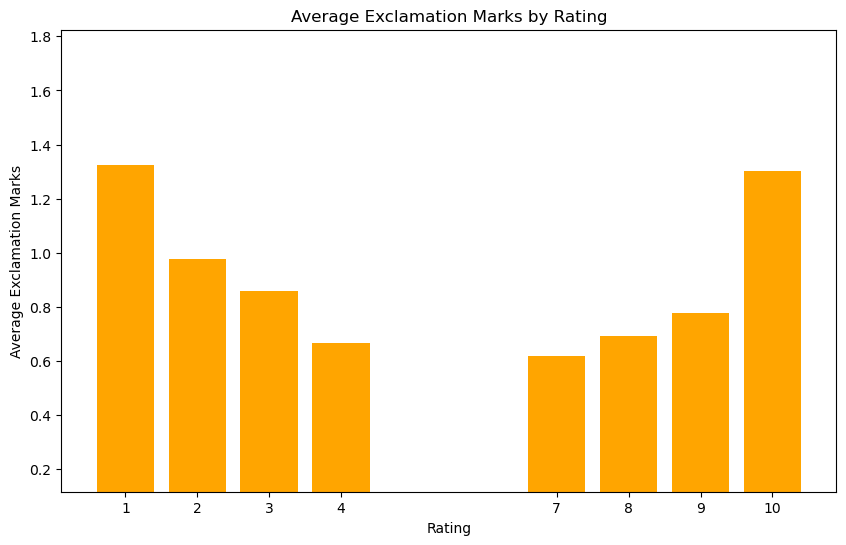

In [46]:
# Adjust the scale so the y-axis doesn't start from 0 for exclamation marks
plt.figure(figsize=(10, 6))
plt.bar(result_df['rating'], result_df['avg_exclamation_marks'], color='orange')

# Add titles and labels
plt.title('Average Exclamation Marks by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Exclamation Marks')

# Set y-axis limits to start from the minimum value of avg_exclamation_marks
plt.ylim(min(result_df['avg_exclamation_marks']) - 0.5, max(result_df['avg_exclamation_marks']) + 0.5)

# Show the plot
plt.xticks(result_df['rating'])  # Ensure all ratings are shown on x-axis
plt.show()


**Inference :**
> The chart shows the average number of exclamation marks by movie rating. Reviews with lower ratings (1–4) tend to have more exclamation marks, with a noticeable peak for reviews rated 1. This suggests that more negative reviews are often written with heightened emotional intensity, possibly reflecting frustration or dissatisfaction. On the other hand, reviews with higher ratings (7, 8, 9, and 10) show a moderate but noticeable increase in exclamation marks, peaking again at rating 10, indicating that very positive reviews may also reflect heightened excitement or enthusiasm. This suggests that extreme ratings, both low and high, are associated with more expressive language.

**f. Review Length Distribution by Rating** *
- Explore how review lengths (word count) are distributed across different movie ratings:
  - Do longer reviews tend to have higher or lower ratings?

In [47]:
%%sparksql
SELECT rating, AVG(word_count) AS avg_word_count
FROM movie_reviews_view
GROUP BY rating
ORDER BY rating


rating,avg_word_count
1,202.05232558139534
2,220.3206964954816
3,238.88965939220884
4,241.2396819386596
7,247.98746605389596
8,238.47381033892503
9,232.03422716372356
10,200.70230586288906


In [48]:
# Run the Spark SQL query and convert results to a Pandas DataFrame
result_df = spark.sql("""
    SELECT rating, AVG(word_count) AS avg_word_count
    FROM movie_reviews_view
    GROUP BY rating
    ORDER BY rating
""").toPandas()


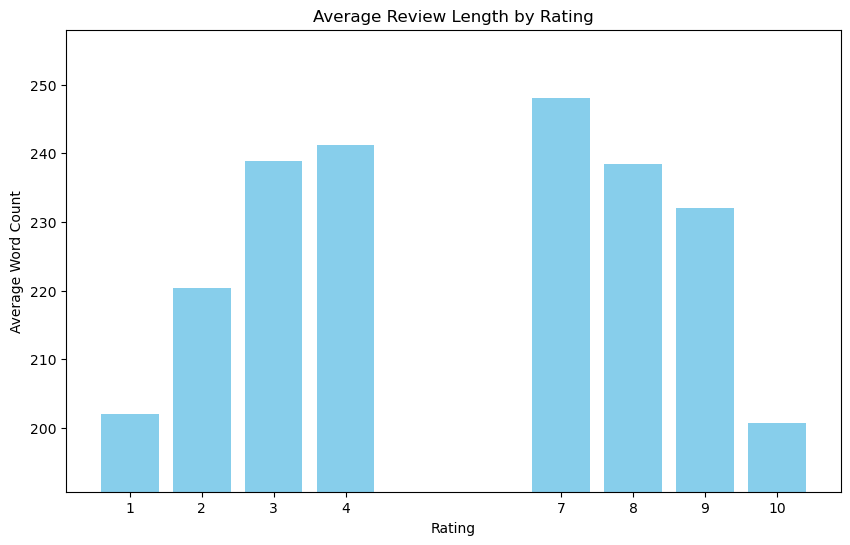

In [49]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(result_df['rating'], result_df['avg_word_count'], color='skyblue')

# Add titles and labels
plt.title('Average Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Word Count')
plt.xticks(result_df['rating'])

# Set y-axis limits
plt.ylim(min(result_df['avg_word_count']) - 10, max(result_df['avg_word_count']) + 10)

# Show the plot
plt.show()

**Inference :** 
> The chart illustrates the average review length by movie rating. Reviews for mid-range ratings (3 to 7) tend to be the longest, suggesting that users with moderate opinions provide more detailed feedback. On the other hand, reviews with extreme ratings (1 and 10) are the shortest, which may indicate that users with very strong positive or negative opinions express their sentiments more succinctly. This pattern suggests that users with neutral or mixed feelings are more likely to elaborate, while those with extreme views may prefer more concise expressions of their opinion.

**g. Word Cloud: Most Common Words in Positive and Negative Reviews**
- Generate word clouds to visualize the most frequently used words in:
  - Positive reviews (highly rated movies) 
  - Negative reviews (low-rated movies)

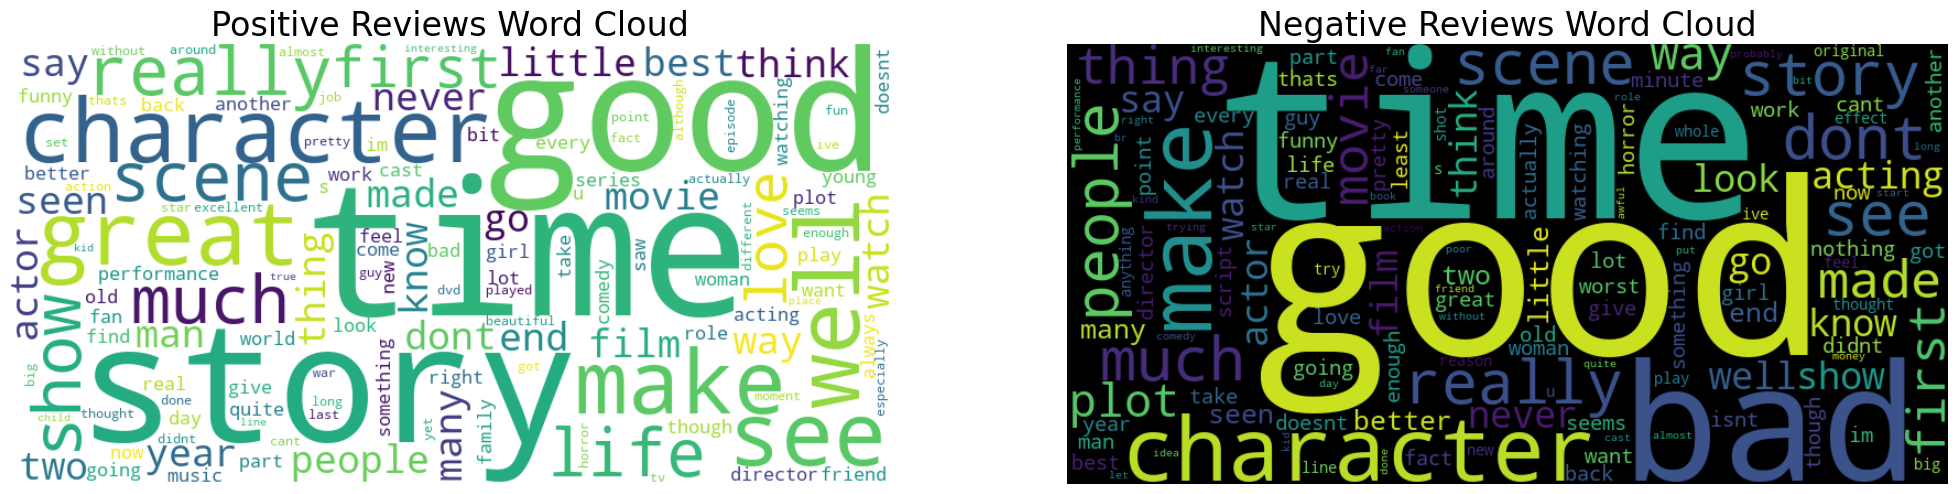

In [50]:
# Fetch positive reviews from the temporary view
positive_reviews_df = spark.sql("SELECT review FROM movie_reviews_view WHERE sentiment = 1")

# Fetch negative reviews from the temporary view
negative_reviews_df = spark.sql("SELECT review FROM movie_reviews_view WHERE sentiment = 0")

# Tokenize the review text into individual words and explode to flatten the array
positive_words = positive_reviews_df.withColumn("word", F.explode(F.split(F.col("review"), " ")))
negative_words = negative_reviews_df.withColumn("word", F.explode(F.split(F.col("review"), " ")))

# Count the frequency of each word in positive reviews
positive_word_freq = positive_words.groupBy("word").count().orderBy(F.desc("count")).filter(F.col("word") != "")

# Count the frequency of each word in negative reviews
negative_word_freq = negative_words.groupBy("word").count().orderBy(F.desc("count")).filter(F.col("word") != "")

# Collect the top 150 words for positive and negative reviews
positive_words_list = positive_word_freq.limit(150).select("word").rdd.flatMap(lambda x: x).collect()
negative_words_list = negative_word_freq.limit(150).select("word").rdd.flatMap(lambda x: x).collect()

# Create text for word clouds
positive_words_text = " ".join(positive_words_list)
negative_words_text = " ".join(negative_words_list)

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_words_text)

# Plotting the word clouds
plt.figure(figsize=(25, 15))

# Positive review word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title("Positive Reviews Word Cloud", fontsize=24)
plt.axis('off')

# Negative review word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title("Negative Reviews Word Cloud", fontsize=24)
plt.axis('off')

plt.show()


**Inference**
> The word clouds for positive and negative reviews show some interesting patterns. In both sentiments, the words "good," "time," and "character" are prominent, suggesting that these themes are important in movie reviews regardless of the sentiment. However, in negative reviews, the word "bad" appears frequently, reflecting dissatisfaction, while positive reviews contain more neutral words like "story" and "scene." This shows that while both positive and negative reviews discuss similar aspects of movies, the tone and specific descriptive words differ based on sentiment.

# Conclusion:

After conducting the exploratory data analysis (EDA), here are the key findings:

   - The dataset has a balanced distribution of positive and negative reviews, which makes it suitable for sentiment analysis.
   - Positive reviews are strongly correlated with higher average ratings, while negative reviews are associated with significantly lower ratings.
   - Negative reviews tend to have more exclamation marks, suggesting stronger emotional expression in reviews with lower ratings.
   - There is no clear relationship between review length and sentiment. Both positive and negative reviews tend to have similar word counts. However, reviews with extreme ratings (very low or very high) tend to be shorter compared to moderate ratings.
   - Positive reviews contain more positive sentiment words, while negative reviews contain more negative words, confirming the effectiveness of the sentiment word count feature.
   - Common words like "good," "time," and "character" appear in both positive and negative reviews, but the word "bad" is prominent in negative reviews.


Overall, The EDA reveals strong relationships between sentiment and ratings, exclamation mark usage, and sentiment words, while review length does not significantly differ between sentiments. These findings provide a clear direction for further sentiment analysis and model development.


# Part2 - Predictive Analytics

From the above EDA it is conclusive that the features like exclamation marks, count of sentiment words, has good impact on the Target feature - `Sentiment`

### Data Preperation and Preprocessing Reassessment

In [6]:
# Load the DataFrame from the persistent table

reviews_df = spark.table("movie_reviews_db.movie_reviews")

In [7]:
# Check the updated DataFrame schema
reviews_df.printSchema()

root
 |-- review: string (nullable = true)
 |-- sentiment: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- exclamation_count: integer (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- positive_word_count: integer (nullable = true)
 |-- negative_word_count: integer (nullable = true)



### Data Preparation and Transformation Pipeline

After completing initial data preparation and feature engineering prior to EDA, the dataset is now clean and ready for modeling. 

To further optimize the data for predictive analysis, we apply transformations, including TF-IDF vectorization and feature scaling, within a single SparkML pipeline.

#### TF-IDF Vectorization
To capture the importance of terms in each review, we use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization. This transformation emphasizes meaningful words by down-weighting common terms, helping to reveal sentiment patterns. Since tokenization was removed earlier, we reapply it to the `review` column, compute term frequencies using `HashingTF`, and apply `IDF` to obtain the final TF-IDF vector. Given an average review length of around 250 words, setting `numFeatures` to 3000 balances term diversity and memory usage.

#### Drop Redundant Columns
   - The `review` column is dropped, as its information is now captured in `tfidf_features`.
   - The `rating` column is excluded to avoid potential data leakage, as it closely correlates with the target variable `sentiment`.
   
#### Feature Selection and Scaling
To prepare the data for modeling, we assemble and scale relevant features as follows:

1. **Feature Assembly**:
   - Using `VectorAssembler`, we combine selected numeric and TF-IDF features into a single vector column, `assembled_features`, for streamlined model input. The features included are:
     - `exclamation_count`: Reflects emotional emphasis in reviews.
     - `word_count`: Represents review length, potentially correlating with sentiment.
     - `positive_word_count` and `negative_word_count`: Capture occurrences of sentiment-specific words.
     - `tfidf_features`: Encodes term importance, highlighting sentiment-related terms.

2. **Scaling and Normalization**:
   - To ensure proportional feature contributions, we apply `MinMaxScaler` to `assembled_features`. Although `tfidf_features` is normalized, scaling the other numeric columns ensures uniformity, preventing any single feature from overly influencing the model.

The final result is a single column, `scaled_features`, containing all necessary features in a standardized format, ready for machine learning models. This setup improves model performance by ensuring balanced feature contributions.


In [8]:
# Train-test split
train_df, test_df = reviews_df.randomSplit([0.8, 0.2], seed=42)

In [9]:
# 1. Tokenize the review text
tokenizer = Tokenizer(inputCol="review", outputCol="tokenized_words")

# 2. HashingTF to compute term frequencies
hashingTF = HashingTF(inputCol="tokenized_words", outputCol="raw_features", numFeatures=3000)

# 3. IDF to calculate TF-IDF scores
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")

# 4. Chi-Squared Selector to keep top 200 features
selector = ChiSqSelector(numTopFeatures=200, featuresCol="tfidf_features", outputCol="selected_features", labelCol="sentiment")

# 5. Assemble relevant features into a single vector column(This step itself includes feature selection and also dropping the unnecessary columns by not selecting them.)
assembler = VectorAssembler(
    inputCols=["exclamation_count", "word_count", "positive_word_count", "negative_word_count", "selected_features"],
    outputCol="assembled_features"
)

# 6. Scale the assembled features
scaler = MinMaxScaler(inputCol="assembled_features", outputCol="scaled_features")

# Common stages for preprocessing
preprocessing_stages = [tokenizer, hashingTF, idf, selector, assembler, scaler]

## Model Selection

### 1. Logistic Regression
- **Interpretability**: Logistic Regression is well-suited for binary classification tasks, offering high interpretability by clearly indicating each feature's impact on predicting positive or negative sentiment.
- **Efficiency on Sparse Data**: It performs effectively with sparse TF-IDF data, making it a practical choice for text classification.
- **Scalability**: Logistic Regression is computationally efficient, providing a strong and reliable baseline for comparison with more complex models.

### 2. Random Forest Classifier
- **Non-Linearity**: Random Forests capture complex, non-linear relationships, which can enhance performance when dealing with nuanced text data.
- **Feature Importance**: The model offers insight into which features (e.g., words) most significantly impact sentiment, aiding in feature refinement and understanding.
- **Noise Tolerance**: Random Forests are known for their robustness against noise, making them a dependable choice for handling diverse and varied content in text data.

### 3. Gradient-Boosted Trees (GBT) Classifier
- **Boosting Accuracy**: GBTs iteratively improve accuracy by focusing on difficult-to-classify sentiment patterns, enhancing performance.
- **Suitability for Sparse Data**: This model handles sparse TF-IDF data well, ensuring effective use of term-weighted features.
- **Handling Complexity**: GBTs capture intricate sentiment patterns, providing a performance edge in tasks requiring nuanced sentiment classification.


# Choosing Evaluation Metrics

In the context of the `movie_reviews` dataset, where the goal is to classify reviews as positive or negative, `areaUnderROC` (AUC-ROC) is particularly suitable as an evaluation metric for several reasons:

### 1. Capturing Sentiment Separation
   AUC-ROC assesses the model’s ability to separate positive reviews from negative ones, capturing sentiment intensity nuances across varied expressions in reviews. By ranking positive reviews higher than negative ones across multiple thresholds, AUC-ROC enables accurate identification of sentiment in diverse text data.

### 2. Balanced Class Performance
   Given that movie reviews often have a balanced mix of positive and negative sentiments, AUC-ROC helps ensure that the model performs well across both classes, preventing bias toward either class. This balanced perspective is particularly useful in sentiment analysis, where both classifications carry significant value.

### 3. Threshold Flexibility
   The classification threshold (e.g., 0.5 in logistic regression) may not always yield optimal results due to varied sentiment intensities. AUC-ROC evaluates model performance across all possible thresholds, providing a comprehensive understanding of classification capabilities without depending on a single threshold.

### 4. Cross-Model Comparison
   With multiple models in this project (Logistic Regression, Random Forest, and Gradient-Boosted Trees), AUC-ROC offers a standardized approach for comparison. It emphasizes how well each model ranks positive versus negative reviews, supporting a fair evaluation and aiding in the selection of the most effective model.

In summary, using `areaUnderROC` for movie review classification enables balanced, threshold-independent evaluation, making it an ideal metric for accurately assessing each model’s sentiment prediction performance across a wide range of reviews.


In [10]:
### Model metrics
# Define the schema for metrics_df
metrics_schema = StructType([
    StructField("Model", StringType(), True),
    StructField("AUC-ROC", DoubleType(), True),
    StructField("AUC-PR", DoubleType(), True),
    StructField("Accuracy", DoubleType(), True),
    StructField("Precision", DoubleType(), True),
    StructField("Recall", DoubleType(), True),
    StructField("F1-Score", DoubleType(), True)
])

metrics_df = spark.createDataFrame([], schema=metrics_schema)

# Define evaluators
evaluator_roc = BinaryClassificationEvaluator(labelCol="sentiment", metricName="areaUnderROC")
evaluator_pr = BinaryClassificationEvaluator(labelCol="sentiment", metricName="areaUnderPR")
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="sentiment", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="sentiment", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="sentiment", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="sentiment", metricName="f1")


# Function to evaluate each model and add metrics to metrics_df
def evaluate_and_log_model(test_data, predictions, model_name="Model"):
    # predictions = model.transform(test_data)
    
    # Calculate each metric
    auc_roc = round(evaluator_roc.evaluate(predictions), 6)
    auc_pr = round(evaluator_pr.evaluate(predictions), 6)
    accuracy = round(evaluator_accuracy.evaluate(predictions), 6)
    precision = round(evaluator_precision.evaluate(predictions), 6)
    recall = round(evaluator_recall.evaluate(predictions), 6)
    f1_score = round(evaluator_f1.evaluate(predictions), 6)
    
    # Create a new row with the metrics
    metrics_row = Row(
        Model=model_name,
        **{
            "AUC-ROC": auc_roc,
            "AUC-PR": auc_pr,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score,
        }
    )
    
    # Convert row to DataFrame and append to metrics_df
    new_metrics_df = spark.createDataFrame([metrics_row])
    global metrics_df
    metrics_df = metrics_df.union(new_metrics_df)

In [11]:
# Define the model stages
lr = LogisticRegression(featuresCol="scaled_features", labelCol="sentiment")
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="sentiment", numTrees=20)
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="sentiment", maxIter=10)

In [12]:
# Create Complete Pipeline for each model
lr_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, selector, assembler, scaler, lr])
rf_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, selector, assembler, scaler, rf])
gbt_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, selector, assembler, scaler, gbt])

In [13]:
# Logistic Regression
lr_model = lr_pipeline.fit(train_df)
lr_predictions = lr_model.transform(test_df)
evaluate_and_log_model(test_df, lr_predictions, model_name="Logistic Regression")
metrics_df.show()

+-------------------+-------+--------+--------+---------+-------+--------+
|              Model|AUC-ROC|  AUC-PR|Accuracy|Precision| Recall|F1-Score|
+-------------------+-------+--------+--------+---------+-------+--------+
|Logistic Regression|0.90839|0.902674| 0.83202| 0.832214|0.83202|0.832017|
+-------------------+-------+--------+--------+---------+-------+--------+



In [14]:
# Random Forest Evaluation
rf_model = rf_pipeline.fit(train_df)
rf_predictions = rf_model.transform(test_df)
evaluate_and_log_model(test_df, rf_predictions, model_name="Random Forest")
metrics_df.show()

+-------------------+-------+--------+--------+---------+--------+--------+
|              Model|AUC-ROC|  AUC-PR|Accuracy|Precision|  Recall|F1-Score|
+-------------------+-------+--------+--------+---------+--------+--------+
|Logistic Regression|0.90839|0.902674| 0.83202| 0.832214| 0.83202|0.832017|
|      Random Forest|0.82047|0.808765|0.736923|  0.73975|0.736923|0.736346|
+-------------------+-------+--------+--------+---------+--------+--------+



In [15]:
# Gradient-Boosted Trees Evaluation
gbt_model = gbt_pipeline.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
evaluate_and_log_model(test_df, gbt_predictions, model_name="Gradient Boosting")
metrics_df.show()

+-------------------+--------+--------+--------+---------+--------+--------+
|              Model| AUC-ROC|  AUC-PR|Accuracy|Precision|  Recall|F1-Score|
+-------------------+--------+--------+--------+---------+--------+--------+
|Logistic Regression| 0.90839|0.902674| 0.83202| 0.832214| 0.83202|0.832017|
|      Random Forest| 0.82047|0.808765|0.736923|  0.73975|0.736923|0.736346|
|  Gradient Boosting|0.822701|0.814092|0.736104| 0.736254|0.736104|0.736102|
+-------------------+--------+--------+--------+---------+--------+--------+



### Hyper Parameter Tuning

**1. Logistic regression**

In [16]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="sentiment")

# Define parameter grid for Logistic Regression
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.05, 0.1, 0.2])
                 .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.5])  # Fewer, centered values
                 .build())

# Set up cross-validation
lr_cv = CrossValidator(estimator=lr_pipeline,
                       estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator_roc,  # Assuming AUC-ROC as the main metric
                       numFolds=5)  # Increased folds for more robust validation

# Fit the model using cross-validation
lr_cv_model = lr_cv.fit(train_df)

# Evaluate on test data
lr_best_model = lr_cv_model.bestModel
lr_predictions = lr_best_model.transform(test_df)

In [17]:
# Evaluate the best Logistic Regression model on test data
lr_predictions = lr_best_model.transform(test_df)
evaluate_and_log_model(test_df, lr_predictions, "Logistic Regression (Tuned)")
metrics_df.show()

+--------------------+--------+--------+--------+---------+--------+--------+
|               Model| AUC-ROC|  AUC-PR|Accuracy|Precision|  Recall|F1-Score|
+--------------------+--------+--------+--------+---------+--------+--------+
| Logistic Regression| 0.90839|0.902674| 0.83202| 0.832214| 0.83202|0.832017|
|       Random Forest| 0.82047|0.808765|0.736923|  0.73975|0.736923|0.736346|
|   Gradient Boosting|0.822701|0.814092|0.736104| 0.736254|0.736104|0.736102|
|Logistic Regressi...| 0.90839|0.902683| 0.83202| 0.832214| 0.83202|0.832017|
+--------------------+--------+--------+--------+---------+--------+--------+



 **2. Random Forest**

In [18]:
535
# Define Random Forest model
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="sentiment")

# Define the parameter grid for Random Forest
rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [10, 15])  # Number of trees
                 .addGrid(rf.maxDepth, [5, 10])    # Depth of trees
                 .build())

# Create Complete Pipeline for Random Forest
rf_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, selector, assembler, scaler, rf])

# Set up cross-validation for Random Forest
rf_cv = CrossValidator(estimator=rf_pipeline,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator_roc,
                       numFolds=5) 

# Train the model using cross-validation and get the best model
rf_cv_model = rf_cv.fit(train_df)
rf_best_model = rf_cv_model.bestModel

In [19]:
# Evaluate the best Random Forest model on test data
rf_predictions = rf_best_model.transform(test_df)
evaluate_and_log_model(test_df, rf_predictions, "Random Forest (Tuned)")
metrics_df.show()

+--------------------+--------+--------+--------+---------+--------+--------+
|               Model| AUC-ROC|  AUC-PR|Accuracy|Precision|  Recall|F1-Score|
+--------------------+--------+--------+--------+---------+--------+--------+
| Logistic Regression| 0.90839|0.902674| 0.83202| 0.832214| 0.83202|0.832017|
|       Random Forest| 0.82047|0.808765|0.736923|  0.73975|0.736923|0.736346|
|   Gradient Boosting|0.822701|0.814092|0.736104| 0.736254|0.736104|0.736102|
|Logistic Regressi...| 0.90839|0.902683| 0.83202| 0.832214| 0.83202|0.832017|
|Random Forest (Tu...|0.846432| 0.83622|0.763947| 0.765453|0.763947|0.763728|
+--------------------+--------+--------+--------+---------+--------+--------+



 **3. Gradient Boosting**

In [20]:
# Define GBT model
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="sentiment")

# Define the parameter grid for GBT
gbt_param_grid = (ParamGridBuilder()
                  .addGrid(gbt.maxIter, [10, 15])       # Number of boosting iterations
                  .addGrid(gbt.maxDepth, [5, 10])       # Maximum depth of each tree
                  .build())

# Create Complete Pipeline for GBT
gbt_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, selector, assembler, scaler, gbt])

# Set up cross-validation for GBT
gbt_cv = CrossValidator(estimator=gbt_pipeline,
                        estimatorParamMaps=gbt_param_grid,
                        evaluator=evaluator_roc,
                        numFolds=5)  

# Train the model using cross-validation and get the best model
gbt_cv_model = gbt_cv.fit(train_df)
gbt_best_model = gbt_cv_model.bestModel


In [21]:
# Evaluate the best Gradient Boost model on test data
gbt_predictions = gbt_best_model.transform(test_df)
evaluate_and_log_model(test_df, gbt_predictions, "Gradient Boost (Tuned)")
metrics_df.show()

+--------------------+--------+--------+--------+---------+--------+--------+
|               Model| AUC-ROC|  AUC-PR|Accuracy|Precision|  Recall|F1-Score|
+--------------------+--------+--------+--------+---------+--------+--------+
| Logistic Regression| 0.90839|0.902674| 0.83202| 0.832214| 0.83202|0.832017|
|       Random Forest| 0.82047|0.808765|0.736923|  0.73975|0.736923|0.736346|
|   Gradient Boosting|0.822701|0.814092|0.736104| 0.736254|0.736104|0.736102|
|Logistic Regressi...| 0.90839|0.902683| 0.83202| 0.832214| 0.83202|0.832017|
|Random Forest (Tu...|0.846432| 0.83622|0.763947| 0.765453|0.763947|0.763728|
|Gradient Boost (T...|0.838698|0.825917|0.758215|  0.75893|0.758215|0.758129|
+--------------------+--------+--------+--------+---------+--------+--------+



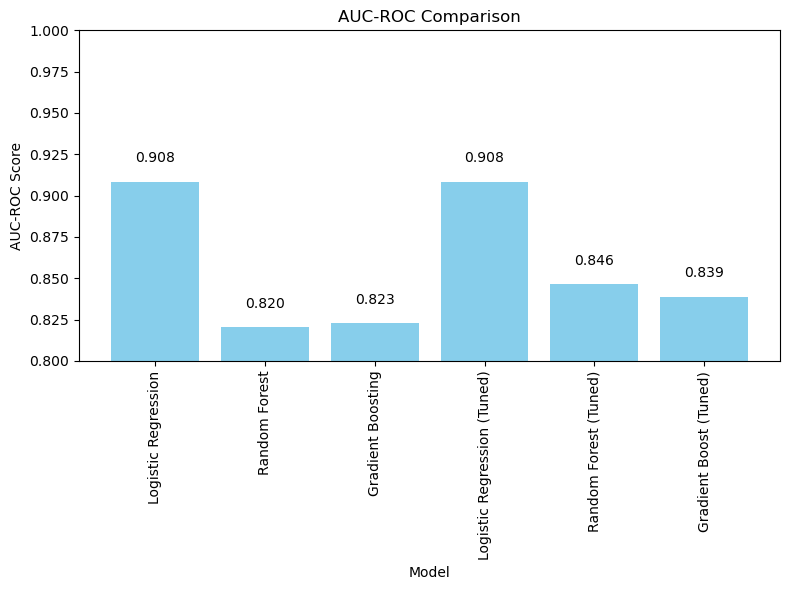

In [26]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame for visualization
metrics_pandas_df = metrics_df.toPandas()

# Sort the DataFrame by AUC-ROC values in descending order
# metrics_pandas_df = metrics_pandas_df.sort_values(by='AUC-ROC', ascending=False)

# Plot AUC-ROC comparison
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting AUC-ROC with labels
bars = ax.bar(metrics_pandas_df['Model'], metrics_pandas_df['AUC-ROC'], color='skyblue')
ax.set_title('AUC-ROC Comparison')
ax.set_ylabel('AUC-ROC Score')
ax.set_ylim(0.8, 1.0)
ax.set_xlabel('Model')

# Set x-axis labels to be vertical
plt.xticks(rotation=90)

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Inference
The model performance results indicate that Logistic Regression outperformed both Random Forest and Gradient-Boosted Trees in sentiment classification, achieving the highest AUC-ROC and AUC-PR scores. Its efficiency and interpretability make it particularly suitable for this binary task. Although Random Forest and Gradient-Boosted Trees benefited from hyperparameter tuning, Logistic Regression consistently yielded superior predictive power with minimal computational overhead. This outcome suggests that a simpler, linear approach may be effective for text-based sentiment analysis in movie reviews, particularly when using well-engineered features such as TF-IDF and sentiment word counts.

## Conclusion

The analysis of the IMDb movie review dataset, leveraging PySpark for sentiment classification, demonstrated effective preprocessing, feature engineering, exploratory data analysis (EDA), and model evaluation. This dataset, with its polarized reviews, proved ideal for binary sentiment classification. By utilizing features such as term frequency-inverse document frequency (TF-IDF), sentiment word counts, exclamation marks, and word count, we constructed an informative feature set for model training.

### Key Observations and Conclusions:

1. **Data Insights and Feature Relevance:**
   - EDA revealed that certain features, such as the count of positive and negative sentiment words, exclamation marks, and ratings, are indicative of sentiment. Positive reviews were associated with higher ratings and fewer exclamation marks, while negative reviews had lower ratings and more intense language.
   - Both positive and negative reviews shared thematic elements but used distinct language styles, underscoring the importance of word choice in sentiment prediction.

2. **Model Evaluation and Performance:**
   - Logistic Regression emerged as the top-performing model with an AUC-ROC score of 0.9084 and an AUC-PR score of 0.9027. Its interpretability and computational efficiency made it a strong candidate for classifying sentiment in movie reviews.
   - The tuned models showed improved performance for Random Forest (AUC-ROC 0.8454, AUC-PR 0.8317) and Gradient Boosting (AUC-ROC 0.8389, AUC-PR 0.8277) compared to their base versions, though Logistic Regression still led across all metrics.
   - Each model effectively captured the dataset’s sentiment patterns, with AUC-ROC selected as the primary evaluation metric for its balanced view of classification performance across thresholds.

3. **Business Implications:**
   - Applying sentiment analysis in the movie industry offers valuable insights into audience preferences, allowing companies to tailor content recommendations, guide future productions, and optimize marketing strategies. For instance, streaming platforms could integrate sentiment-based filtering for personalized recommendations, enhancing user engagement.
   - The interpretability of the Logistic Regression model provides additional value, enabling stakeholders to understand which features influence positive or negative sentiment, thus refining content offerings based on viewer feedback.

4. **Limitations and Future Improvements:**
   - The linear nature of Logistic Regression may overlook complex relationships within the data. Future iterations could explore ensemble methods that combine linear and non-linear models for deeper sentiment insights.
   - Additional feature engineering, such as semantic analysis or context-based sentiment classification, could improve accuracy by capturing more nuanced aspects of movie reviews.
   - To handle outliers and improve model robustness, future models could incorporate techniques to mitigate bias in extreme review ratings.

### Summary

Logistic Regression provided the most reliable results for this binary sentiment classification task, balancing efficiency, interpretability, and predictive accuracy. Future work could build on these findings by incorporating advanced feature engineering and experimenting with deep learning approaches, potentially further improving sentiment classification in the movie review domain.
